In [1]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd


#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('bmh')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]

In [2]:
!rsync -avz cluster.ies:/mnt/home/dhuseljic/mlflow/pseudo_batch /home/dhuseljic/mlflow

receiving incremental file list

sent 14,965 bytes  received 4,628,817 bytes  114,661.28 bytes/sec
total size is 45,925,964  speedup is 9.89


In [17]:
dataset = 'cifar10'
client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_gamma_ablation')
# client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_updating.db')
# client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_updating_initds')
experiment_id = client.get_experiment_by_name('updating').experiment_id
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 280 experiments


## Gamma Ablation

In [89]:
dataset = 'dbpedia'
client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_gamma_ablation')
experiment_id = client.get_experiment_by_name('updating').experiment_id

runs = []
query_list = [
    "parameter.num_init_samples='50'", "parameter.num_new_samples = '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]'",
    # "parameter.num_init_samples='50'", "parameter.num_new_samples = '[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]'",
    # "parameter.num_init_samples='100'", "parameter.num_new_samples = '[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]'",
    "parameter.likelihood='gaussian'"
    # "parameter.model.num_epochs='200'"
    "parameter.update_lmb = '1'",
    # "parameter.optimizer.lr = '0.1'",
]
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
print('Found {} experiments'.format(len(runs_)))
runs.extend(runs_)

Found 60 experiments


In [92]:
all_gammas = np.unique([float(run.data.params['update_gamma']) for run in runs])
all_gammas = [1.0, 5.0, 10.0, 30.0]
all_num_new_samples = {gamma: [] for gamma in all_gammas}
all_base_accs = {gamma: [] for gamma in all_gammas}
all_mc_update_accs = {gamma: [] for gamma in all_gammas}
all_update_accs = {gamma: [] for gamma in all_gammas}
all_retrain_accs = {gamma: [] for gamma in all_gammas}


for gamma in all_gammas:
    runs_gamma = [run for run in runs if float(run.data.params['update_gamma']) == gamma]
    runs_gamma = sorted(runs_gamma, key=lambda run: int(run.data.params['random_seed']))

    for run in runs_gamma:
        num_init_samples = run.data.params['num_init_samples']
        if len(run.data.metrics) == 0: continue
        num_new_samples = [m.step for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
        base_acc = client.get_metric_history(run.info.run_id, 'base_accuracy')[0].value
        mc_update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_accuracy')]
        update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
        retrain_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'retrained_accuracy')]
        if len(update_acc) != 10:
            continue

        all_num_new_samples[gamma].append(num_new_samples)
        all_base_accs[gamma].append(base_acc)
        all_mc_update_accs[gamma].append(mc_update_acc)
        all_update_accs[gamma].append(update_acc)
        all_retrain_accs[gamma].append(retrain_acc)

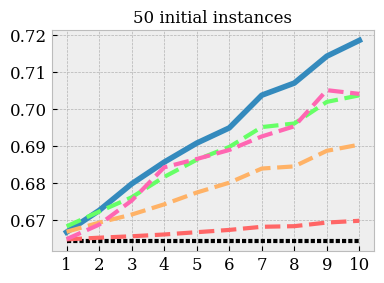

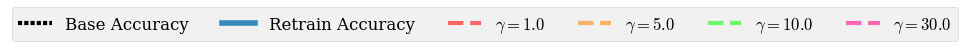

In [93]:
base_acc_mean = np.mean(all_base_accs[all_gammas[0]])
num_new_samples_mean = np.mean(all_num_new_samples[all_gammas[0]], axis=0)
retrain_acc_mean = np.mean(all_retrain_accs[all_gammas[0]], axis=0)
retrain_acc_stderr = np.std(all_retrain_accs[all_gammas[0]], axis=0) / np.sqrt(np.shape(all_retrain_accs[all_gammas[0]])[0])

plt.figure(figsize=(4, 3))
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
# plt.fill_between(num_new_samples_mean, retrain_acc_mean - retrain_acc_stderr, retrain_acc_mean + retrain_acc_stderr, alpha=.2, zorder=3)

colors = ["#FF6666", "#FFB266", "#66FF66",  "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347", "#FF6666", "#FFB266", "#66FF66",  "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
# colors = ["#FF6666", "#FFB266", "#66FF66",  "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
for i_gamma, gamma in enumerate(all_gammas):
    update_acc_mean = np.mean(all_update_accs[gamma], axis=0)
    update_acc_stderr = np.std(all_update_accs[gamma], axis=0) / np.sqrt(np.shape(all_retrain_accs[gamma])[0])
    plt.plot(num_new_samples_mean, update_acc_mean, '--', label=f'$\gamma = {gamma}$', zorder=10, linewidth=3, color=colors[i_gamma])
    # plt.fill_between(num_new_samples_mean, update_acc_mean - update_acc_stderr, update_acc_mean + update_acc_stderr, alpha=.2)

plt.title(f"{int(runs[0].data.params['num_init_samples'])} initial instances")
plt.xticks(num_new_samples_mean)
# plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f'plots/{dataset}_gamma_ablation.pdf', bbox_inches='tight', pad_inches=.1)
plt.show()

# plt.legend(bbox_to_anchor=(1, 1))
plt.figure(figsize=(4, 3))
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
# plt.fill_between(num_new_samples_mean, retrain_acc_mean - retrain_acc_stderr, retrain_acc_mean + retrain_acc_stderr, alpha=.2, zorder=3)

for i_gamma, gamma in enumerate(all_gammas):
    update_acc_mean = np.mean(all_update_accs[gamma], axis=0)
    update_acc_stderr = np.std(all_update_accs[gamma], axis=0) / np.sqrt(np.shape(all_retrain_accs[gamma])[0])
    plt.plot(num_new_samples_mean, update_acc_mean, '--', label=f'$\gamma = {gamma}$', zorder=10, linewidth=3, color=colors[i_gamma])
    # plt.fill_between(num_new_samples_mean, update_acc_mean - update_acc_stderr, update_acc_mean + update_acc_stderr, alpha=.2)

plt.tight_layout()
plt.gca().set_visible(False)
plt.gcf().legend(ncol=6)
plt.savefig(f'plots/gamma_legend.pdf', bbox_inches='tight', pad_inches=.1)

## Check init dataset size

In [78]:
dataset = 'banking77'
#  client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_updating.db')
client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_initds')
experiment_id = client.get_experiment_by_name('updating').experiment_id
runs = client.search_runs(experiment_ids=experiment_id)

runs = []
init_query_list = [
    # "parameter.num_new_samples = '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]'",
    "parameter.likelihood='gaussian'"
    "parameter.update_gamma='10'"
]

query_list = init_query_list # + ["parameter.num_init_samples='10'"]
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 200 experiments


In [79]:
all_num_init = np.unique([int(run.data.params['num_init_samples']) for run in runs])
print(all_num_init)

all_num_new_samples = {num_init: [] for num_init in all_num_init}
all_base_accs = {num_init: [] for num_init in all_num_init}
all_mc_update_accs = {num_init: [] for num_init in all_num_init}
all_fo_update_accs = {num_init: [] for num_init in all_num_init}
all_update_accs = {num_init: [] for num_init in all_num_init}
all_retrain_accs = {num_init: [] for num_init in all_num_init}


for num_init in all_num_init:
    runs_num_init = [run for run in runs if float(run.data.params['num_init_samples']) == num_init]
    runs_num_init = sorted(runs_num_init, key=lambda run: int(run.data.params['random_seed']))

    for run in runs_num_init:
        num_new_samples = [m.step for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
        base_acc = client.get_metric_history(run.info.run_id, 'base_accuracy')[0].value
        mc_update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_accuracy')]
        fo_update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'fo_updated_accuracy')]
        update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
        retrain_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'retrained_accuracy')]

        all_num_new_samples[num_init].append(num_new_samples)
        all_base_accs[num_init].append(base_acc)
        all_mc_update_accs[num_init].append(mc_update_acc)
        all_fo_update_accs[num_init].append(fo_update_acc)
        all_update_accs[num_init].append(update_acc)
        all_retrain_accs[num_init].append(retrain_acc)

[ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
 1500 1600 1700 1800 1900 2000]


In [80]:
avg_base_accs = {k: np.mean(v) for k, v in all_base_accs.items()}
avg_auc_mc_update_accs = {k: np.mean(v) for k, v in all_mc_update_accs.items()}
avg_auc_fo_update_accs = {k: np.mean(v) for k, v in all_fo_update_accs.items()}
avg_auc_update_accs = {k: np.mean(v) for k, v in all_update_accs.items()}
avg_auc_retrain_accs = {k: np.mean(v) for k, v in all_retrain_accs.items()}

df = pd.DataFrame([avg_base_accs, avg_auc_mc_update_accs, avg_auc_fo_update_accs, avg_auc_update_accs, avg_auc_retrain_accs], index=['Base', 'MC Update', 'FO Update', 'Our Update', 'Retraining']).T
df *= 100
print(df.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrrr}
\toprule
 & Base & MC Update & FO Update & Our Update & Retraining \\
\midrule
100 & 15.37 & 15.46 & 15.72 & 15.96 & 16.12 \\
200 & 25.58 & 25.60 & 25.58 & 25.92 & 26.04 \\
300 & 33.52 & 33.50 & 33.58 & 33.90 & 33.95 \\
400 & 39.52 & 39.54 & 39.49 & 39.84 & 39.89 \\
500 & 44.31 & 44.27 & 44.19 & 44.43 & 44.46 \\
600 & 48.28 & 48.36 & 48.12 & 48.39 & 48.52 \\
700 & 51.78 & 51.76 & 51.54 & 51.93 & 51.89 \\
800 & 54.59 & 54.64 & 54.55 & 54.74 & 54.85 \\
900 & 56.82 & 56.88 & 56.72 & 56.97 & 56.95 \\
1000 & 59.48 & 59.57 & 59.36 & 59.59 & 59.63 \\
1100 & 61.40 & 61.45 & 61.16 & 61.46 & 61.47 \\
1200 & 62.95 & 62.99 & 62.87 & 63.01 & 63.11 \\
1300 & 64.55 & 64.57 & 64.36 & 64.55 & 64.58 \\
1400 & 65.63 & 65.68 & 65.47 & 65.65 & 65.71 \\
1500 & 66.62 & 66.59 & 66.61 & 66.67 & 66.72 \\
1600 & 67.68 & 67.67 & 67.61 & 67.78 & 67.78 \\
1700 & 68.67 & 68.72 & 68.52 & 68.75 & 68.77 \\
1800 & 69.64 & 69.65 & 69.39 & 69.66 & 69.69 \\
1900 & 70.27 & 70.32 & 70.22 & 70.33 & 70.

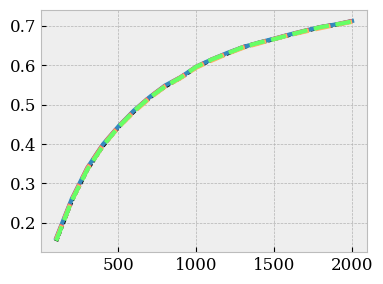

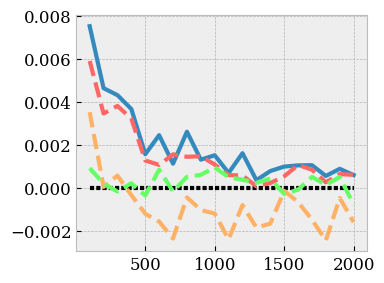

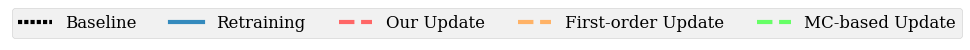

In [81]:
plt.figure(figsize=(4, 3))
plt.plot(all_num_init, avg_base_accs.values(), label='Base', color='black', linewidth=3, linestyle=(0, (1, .5)))
plt.plot(all_num_init, avg_auc_retrain_accs.values(), label='Retraining (10 new)', linewidth=3)
plt.plot(all_num_init, avg_auc_update_accs.values(), label='Our Update', linewidth=3, linestyle='--', color=colors[0])
plt.plot(all_num_init, avg_auc_fo_update_accs.values(), label='First-order Update', linewidth=3, linestyle='--', color=colors[1])
plt.plot(all_num_init, avg_auc_mc_update_accs.values(), label='MC-based Update', linewidth=3, linestyle='--', color=colors[2])
plt.tight_layout()
plt.savefig(f'plots/{dataset}_init_ds.pdf') #, bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(all_num_init, np.subtract(list(avg_base_accs.values()), list(avg_base_accs.values())), label='Baseline', color='black', linewidth=3, linestyle=(0, (1, .5)))
plt.plot(all_num_init, np.subtract(list(avg_auc_retrain_accs.values()), list(avg_base_accs.values())), label='Retraining', linewidth=3)
plt.plot(all_num_init, np.subtract(list(avg_auc_update_accs.values()), list(avg_base_accs.values())), label='Our Update', linewidth=3, linestyle='--', color=colors[0])
plt.plot(all_num_init, np.subtract(list(avg_auc_fo_update_accs.values()), list(avg_base_accs.values())), label='First-order Update', linewidth=3, linestyle='--', color=colors[1])
plt.plot(all_num_init, np.subtract(list(avg_auc_mc_update_accs.values()), list(avg_base_accs.values())), label='MC-based Update', linewidth=3, linestyle='--' , color=colors[2])
plt.tight_layout()
plt.savefig(f'plots/{dataset}_diff_init_ds.pdf')# , bbox_inches='tight', pad_inches=0.1)
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(all_num_init, np.subtract(list(avg_base_accs.values()), list(avg_base_accs.values())), label='Baseline', color='black', linewidth=3, linestyle=(0, (1, .5)))
plt.plot(all_num_init, np.subtract(list(avg_auc_retrain_accs.values()), list(avg_base_accs.values())), label='Retraining', linewidth=3)
plt.plot(all_num_init, np.subtract(list(avg_auc_update_accs.values()), list(avg_base_accs.values())), label='Our Update', linewidth=3, linestyle='--', color=colors[0])
plt.plot(all_num_init, np.subtract(list(avg_auc_fo_update_accs.values()), list(avg_base_accs.values())), label='First-order Update', linewidth=3, linestyle='--', color=colors[1])
plt.plot(all_num_init, np.subtract(list(avg_auc_mc_update_accs.values()), list(avg_base_accs.values())), label='MC-based Update', linewidth=3, linestyle='--' , color=colors[2])

plt.legend()
plt.tight_layout()
plt.gca().set_visible(False)
plt.gcf().legend(ncol=6)
plt.savefig(f'plots/{dataset}_init_ds_legend.pdf', bbox_inches='tight', pad_inches=.1)

## Check New Dataset Size

In [8]:
dataset = 'cifar10'
#  client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_updating.db')
client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_newds_fix')
experiment_id = client.get_experiment_by_name('updating').experiment_id
runs = client.search_runs(experiment_ids=experiment_id)

runs = []
init_query_list = [
    "parameter.num_init_samples = '100'",
    "parameter.num_new_samples = '[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]'",
    # "parameter.num_new_samples = '[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]'",
    "parameter.likelihood = 'gaussian'"
    "parameter.update_gamma = '10'"
]

query_list = init_query_list # + ["parameter.num_init_samples='10'"]
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
runs.extend(runs_)

# query_list = init_query_list + ["parameter.num_init_samples='20'"]
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
# runs.extend(runs_)
# 
# query_list = init_query_list + ["parameter.num_init_samples='30'"]
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
# runs.extend(runs_)
# 
# query_list = init_query_list + ["parameter.num_init_samples='40'"]
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
# runs.extend(runs_)
# 
# query_list = init_query_list + ["parameter.num_init_samples='50'"]
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
# runs.extend(runs_)
# 
# query_list = init_query_list + ["parameter.num_init_samples='50'"]
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
# runs.extend(runs_)
# 
# query_list = init_query_list + ["parameter.num_init_samples='100'"]
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 10 experiments


In [9]:
all_num_new_samples = []
all_base_accs = []
all_mc_update_accs = []
all_fo_update_accs = []
all_update_accs = []
all_retrain_accs = []

runs = sorted(runs, key=lambda run: int(run.data.params['random_seed']))
for run in runs:
    num_init_samples = run.data.params['num_init_samples']
    num_new_samples = [m.step for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
    base_acc = client.get_metric_history(run.info.run_id, 'base_accuracy')[0].value

    update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
    mc_update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_accuracy')]
    fo_update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'fo_updated_accuracy')]

    retrain_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'retrained_accuracy')]

    all_num_new_samples.append(num_new_samples)
    all_base_accs.append(base_acc)
    all_update_accs.append(update_acc)
    all_mc_update_accs.append(mc_update_acc)
    all_fo_update_accs.append(fo_update_acc)
    all_retrain_accs.append(retrain_acc)

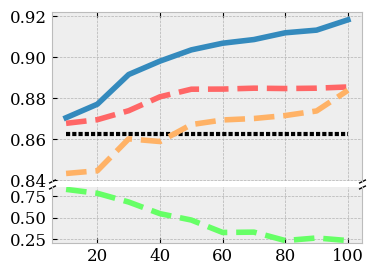

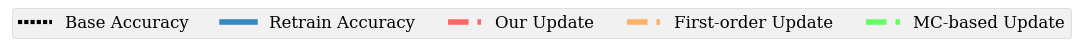

In [10]:
num_new_samples_mean = np.mean(all_num_new_samples, axis=0)

base_acc_mean = np.mean(all_base_accs)
retrain_acc_mean = np.mean(all_retrain_accs, axis=0)
update_acc_mean = np.mean(all_update_accs, axis=0)
fo_update_acc_mean = np.mean(all_fo_update_accs, axis=0)
mc_update_acc_mean = np.mean(all_mc_update_accs, axis=0)



# plt.figure(figsize=(4, 3))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 3), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

plt.sca(ax1)
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
plt.plot(num_new_samples_mean, update_acc_mean, '--', color=colors[0], label='SO Update', linewidth=4, zorder=3)
plt.plot(num_new_samples_mean, fo_update_acc_mean, '--', color=colors[1], label='FO Update', linewidth=4, zorder=3)
plt.sca(ax2)
plt.plot(num_new_samples_mean, mc_update_acc_mean, '--', color=colors[2], label='MC Update', linewidth=4, zorder=3)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.savefig(f'{dataset}_newds.pdf')
plt.show()

plt.figure(figsize=(4, 3))
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
# plt.fill_between(num_new_samples_mean, retrain_acc_mean - retrain_acc_stderr, retrain_acc_mean + retrain_acc_stderr, alpha=.2, zorder=3)
colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
plt.plot(num_new_samples_mean, update_acc_mean, '--', color=colors[0], label='Our Update', linewidth=4, zorder=3)
plt.plot(num_new_samples_mean, fo_update_acc_mean, '--', color=colors[1], label='First-order Update', linewidth=4, zorder=3)
plt.plot(num_new_samples_mean, mc_update_acc_mean, '--', color=colors[2], label='MC-based Update', linewidth=4, zorder=3)

plt.tight_layout()
plt.gca().set_visible(False)
plt.gcf().legend(ncol=6)
plt.savefig(f'newds_legend.pdf')
plt.show()

## Check Times

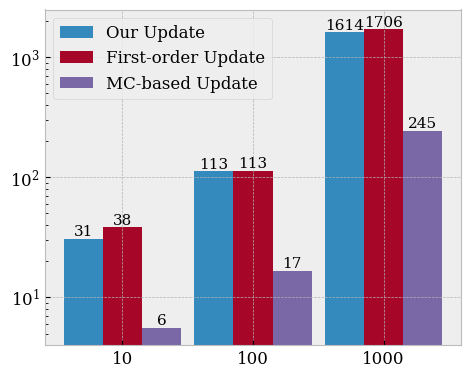

In [62]:
client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:///updating_times_1805.db')
experiment_id = client.get_experiment_by_name('updating').experiment_id
init_query_list = ["parameter.dataset_name = 'cifar10'"]

query_list = init_query_list + ["parameter.num_new_samples = '[10]'", "parameter.num_init_samples = '10'"]
runs_10 = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))

query_list = init_query_list + ["parameter.num_new_samples = '[10]'", "parameter.num_init_samples = '100'"]
runs_100 = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))

query_list = init_query_list + ["parameter.num_new_samples = '[10]'", "parameter.num_init_samples = '1000'"]
runs_1000 = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))

num_init = []
speed_up_mc = []
speed_up_fo = []
speed_up_so = []
for run in runs_10:
    update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'updated_time')])
    mc_update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_time')])
    fo_update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'fo_updated_time')])
    retrain_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'retrained_time')])
    num_init.append(int(run.data.params['num_init_samples']))

    # speed_up_retrain.append(retrain_time / update_time)
    speed_up_so.append(retrain_time / update_time)
    speed_up_mc.append(retrain_time / mc_update_time)
    speed_up_fo.append(retrain_time / fo_update_time)

for run in runs_100:
    update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'updated_time')])
    mc_update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_time')])
    fo_update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'fo_updated_time')])
    retrain_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'retrained_time')])
    num_init.append(int(run.data.params['num_init_samples']))

    speed_up_so.append(retrain_time / update_time)
    speed_up_mc.append(retrain_time / mc_update_time)
    speed_up_fo.append(retrain_time / fo_update_time)

for run in runs_1000:
    update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'updated_time')])
    mc_update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_time')])
    fo_update_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'fo_updated_time')])
    retrain_time = np.mean([m.value for m in client.get_metric_history(run.info.run_id, 'retrained_time')])
    num_init.append(int(run.data.params['num_init_samples']))

    speed_up_so.append(retrain_time / update_time)
    speed_up_mc.append(retrain_time / mc_update_time)
    speed_up_fo.append(retrain_time / fo_update_time)


def add_height_text(bars): 
    import matplotlib.patheffects as pe
    for rect in bars:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.0f}', ha='center', va='bottom', color='k', fontdict=dict(size=11))

plt.figure(figsize=(5, 4))
axis = np.arange(len(speed_up_so))
width = .9
bars_retrain = plt.bar(axis - width/3, speed_up_so,  width=width/3, align='center', label='Our Update')
add_height_text(bars_retrain)
bars_fo = plt.bar(axis , speed_up_fo,  width=width/3, align='center', label='First-order Update')
add_height_text(bars_fo)
bars_mc = plt.bar(axis+width/3, speed_up_mc,  width=width/3, align='center', label='MC-based Update')
add_height_text(bars_mc)

plt.ylim(4, 2500)
plt.xticks(axis, num_init)
plt.tight_layout()
plt.legend()
plt.yscale('log')
plt.savefig('speedup_factor_initds.pdf')

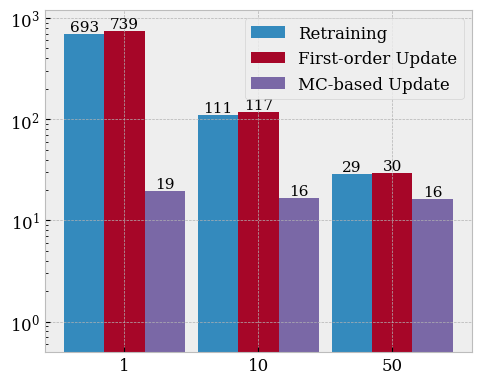

In [65]:
import ast
client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:///updating_times_1805.db')
experiment_id = client.get_experiment_by_name('updating').experiment_id
init_query_list = ["parameter.dataset_name = 'cifar10'"]

query_list = init_query_list + ["parameter.num_new_samples = '[1, 10, 50]'", "parameter.num_init_samples = '100'"]
runs = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))

for run in runs:
    update_time = [m.value for m in client.get_metric_history(run.info.run_id, 'updated_time')]
    mc_update_time = [m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_time')]
    fo_update_time = [m.value for m in client.get_metric_history(run.info.run_id, 'fo_updated_time')]
    retrain_time = [m.value for m in client.get_metric_history(run.info.run_id, 'retrained_time')]

    num_new =  ast.literal_eval(run.data.params['num_new_samples'])
    speed_up_mc = np.divide(retrain_time, mc_update_time)
    speed_up_fo = np.divide(retrain_time, fo_update_time)
    speed_up_so = np.divide(retrain_time,update_time)


plt.figure(figsize=(5, 4))
axis = np.arange(len(speed_up_so))
width = .9
bars_retrain = plt.bar(axis - width/3, speed_up_so,  width=width/3, align='center', label='Retraining')
add_height_text(bars_retrain)
bars_fo = plt.bar(axis , speed_up_fo,  width=width/3, align='center', label='First-order Update')
add_height_text(bars_fo)
bars_mc = plt.bar(axis+width/3, speed_up_mc,  width=width/3, align='center', label='MC-based Update')
add_height_text(bars_mc)

plt.xticks(axis, num_new)
plt.tight_layout()
plt.legend()
plt.yscale('log')
plt.ylim(0.5, 1200)
plt.savefig('speedup_factor_newds.pdf')

## Hyperparameter Search First Order

In [136]:
dataset = 'dbpedia'
client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_gamma_ablation_fo')
experiment_id = client.get_experiment_by_name('updating').experiment_id

runs = []
query_list = [
    "parameter.num_init_samples='50'", "parameter.num_new_samples = '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]'",
    "parameter.optimizer.lr='0.1'"

]
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))
print('Found {} experiments'.format(len(runs_)))
runs.extend(runs_)

Found 50 experiments


In [137]:
all_gammas = np.unique([float(run.data.params['update_gamma_fo']) for run in runs])
# all_gammas = [0.001, 0.01, .005, 0.0001]

all_num_new_samples = {gamma: [] for gamma in all_gammas}
all_base_accs = {gamma: [] for gamma in all_gammas}
all_update_accs = {gamma: [] for gamma in all_gammas}
all_retrain_accs = {gamma: [] for gamma in all_gammas}


for gamma in all_gammas:
    runs_gamma = [run for run in runs if float(run.data.params['update_gamma_fo']) == gamma]
    runs_gamma = sorted(runs_gamma, key=lambda run: int(run.data.params['random_seed']))


    for run in runs_gamma:
        num_init_samples = run.data.params['num_init_samples']
        if len(run.data.metrics) == 0: continue
        num_new_samples = [m.step for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
        base_acc = client.get_metric_history(run.info.run_id, 'base_accuracy')[0].value
        mc_update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_accuracy')]
        update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'fo_updated_accuracy')]
        retrain_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'retrained_accuracy')]
        if len(update_acc) != 10:
            continue

        all_num_new_samples[gamma].append(num_new_samples)
        all_base_accs[gamma].append(base_acc)
        all_update_accs[gamma].append(update_acc)
        all_retrain_accs[gamma].append(retrain_acc)

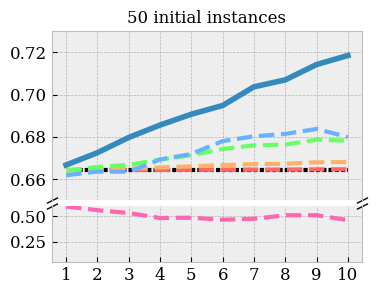

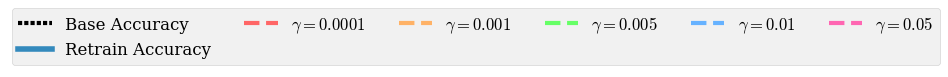

In [138]:
base_acc_mean = np.mean(all_base_accs[all_gammas[0]])
num_new_samples_mean = np.mean(all_num_new_samples[all_gammas[0]], axis=0)
retrain_acc_mean = np.mean(all_retrain_accs[all_gammas[0]], axis=0)
retrain_acc_stderr = np.std(all_retrain_accs[all_gammas[0]], axis=0) / np.sqrt(np.shape(all_retrain_accs[all_gammas[0]])[0])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 3), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

plt.sca(ax1)
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
plt.ylim(plt.ylim())
# plt.fill_between(num_new_samples_mean, retrain_acc_mean - retrain_acc_stderr, retrain_acc_mean + retrain_acc_stderr, alpha=.2, zorder=3)
for ax in (ax1, ax2):
    plt.sca(ax)
    colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
    for i_gamma, gamma in enumerate(all_gammas):
        update_acc_mean = np.mean(all_update_accs[gamma], axis=0)
        update_acc_stderr = np.std(all_update_accs[gamma], axis=0) / np.sqrt(np.shape(all_retrain_accs[gamma])[0])
        plt.plot(num_new_samples_mean, update_acc_mean, '--', label=f'$\gamma = {gamma}$', zorder=10, linewidth=3, color=colors[i_gamma])
        # plt.fill_between(num_new_samples_mean, update_acc_mean - update_acc_stderr, update_acc_mean + update_acc_stderr, alpha=.2)

plt.sca(ax1)
# plt.ylim(0.75, 0.79)
plt.ylim(0.75, 0.79)
plt.title(f"{int(runs[0].data.params['num_init_samples'])} initial instances")
plt.xticks(num_new_samples_mean)


# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.set_ticks_position('none')
ax2.xaxis.tick_bottom()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.set_ylim(0.65, .73)
ax2.set_ylim(0.05, .6)

plt.savefig(f'plots/{dataset}_gamma_fo_ablation.pdf', bbox_inches='tight', pad_inches=.1)
plt.show()

# plt.legend(bbox_to_anchor=(1, 1))
plt.figure(figsize=(4, 3))
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
# plt.fill_between(num_new_samples_mean, retrain_acc_mean - retrain_acc_stderr, retrain_acc_mean + retrain_acc_stderr, alpha=.2, zorder=3)

colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
for i_gamma, gamma in enumerate(all_gammas):
    update_acc_mean = np.mean(all_update_accs[gamma], axis=0)
    update_acc_stderr = np.std(all_update_accs[gamma], axis=0) / np.sqrt(np.shape(all_retrain_accs[gamma])[0])
    plt.plot(num_new_samples_mean, update_acc_mean, '--', label=f'$\gamma = {gamma}$', zorder=10, linewidth=3, color=colors[i_gamma])
    # plt.fill_between(num_new_samples_mean, update_acc_mean - update_acc_stderr, update_acc_mean + update_acc_stderr, alpha=.2)

plt.tight_layout()
plt.gca().set_visible(False)
plt.gcf().legend(ncol=6)
plt.savefig(f'plots/gamma_fo_legend.pdf', bbox_inches='tight', pad_inches=.1)

## Hyperparameter Search MC

In [162]:
dataset = 'dbpedia'
client = mlflow.tracking.MlflowClient(tracking_uri=f'file:////home/dhuseljic/mlflow/pseudo_batch/{dataset}_gamma_ablation_mc')
experiment_id = client.get_experiment_by_name('updating').experiment_id

runs = []
query_list = [
    "parameter.num_init_samples='50'", "parameter.num_new_samples = '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]'",
]
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=' and '.join(query_list))


print('Found {} experiments'.format(len(runs_)))
runs.extend(runs_)

Found 70 experiments


In [163]:
#runs = [run for run in runs if float(run.data.params['update_gamma_mc']) != 1.0]

In [164]:
all_gammas = np.unique([float(run.data.params['update_gamma_mc']) for run in runs])
# all_gammas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
all_num_new_samples = {gamma: [] for gamma in all_gammas}
all_base_accs = {gamma: [] for gamma in all_gammas}
all_update_accs = {gamma: [] for gamma in all_gammas}
all_retrain_accs = {gamma: [] for gamma in all_gammas}


for gamma in all_gammas:
    runs_gamma = [run for run in runs if float(run.data.params['update_gamma_mc']) == gamma]
    runs_gamma = sorted(runs_gamma, key=lambda run: int(run.data.params['random_seed']))


    for run in runs_gamma:
        num_init_samples = run.data.params['num_init_samples']
        if len(run.data.metrics) == 0: continue
        num_new_samples = [m.step for m in client.get_metric_history(run.info.run_id, 'updated_accuracy')]
        base_acc = client.get_metric_history(run.info.run_id, 'base_accuracy')[0].value
        update_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'mc_updated_accuracy')]
        retrain_acc = [m.value for m in client.get_metric_history(run.info.run_id, 'retrained_accuracy')]
        if len(update_acc) != 10:
            continue

        all_num_new_samples[gamma].append(num_new_samples)
        all_base_accs[gamma].append(base_acc)
        all_update_accs[gamma].append(update_acc)
        all_retrain_accs[gamma].append(retrain_acc)

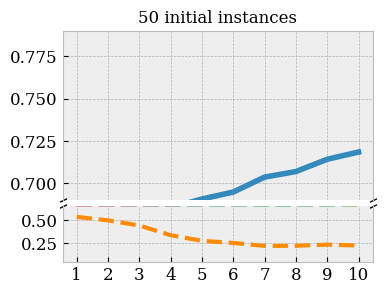

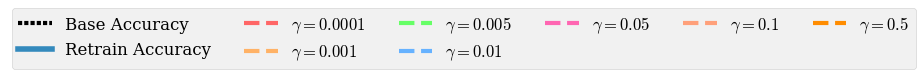

In [165]:
base_acc_mean = np.mean(all_base_accs[all_gammas[0]])
num_new_samples_mean = np.mean(all_num_new_samples[all_gammas[0]], axis=0)
retrain_acc_mean = np.mean(all_retrain_accs[all_gammas[0]], axis=0)
retrain_acc_stderr = np.std(all_retrain_accs[all_gammas[0]], axis=0) / np.sqrt(np.shape(all_retrain_accs[all_gammas[0]])[0])

# plt.figure(figsize=(4, 3))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 3), height_ratios=[3, 1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

plt.sca(ax1)
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
# plt.ylim(plt.ylim())
# plt.fill_between(num_new_samples_mean, retrain_acc_mean - retrain_acc_stderr, retrain_acc_mean + retrain_acc_stderr, alpha=.2, zorder=3)

for ax in [ax1, ax2]:
    plt.sca(ax)
    colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
    for i_gamma, gamma in enumerate(all_gammas):
        update_acc_mean = np.mean(all_update_accs[gamma], axis=0)
        update_acc_stderr = np.std(all_update_accs[gamma], axis=0) / np.sqrt(np.shape(all_retrain_accs[gamma])[0])
        plt.plot(num_new_samples_mean, update_acc_mean, '--', label=f'$\gamma = {gamma}$', zorder=10, linewidth=3, color=colors[i_gamma])
        # plt.fill_between(num_new_samples_mean, update_acc_mean - update_acc_stderr, update_acc_mean + update_acc_stderr, alpha=.2)

plt.sca(ax1)
plt.title(f"{int(runs[0].data.params['num_init_samples'])} initial instances")
plt.xticks(num_new_samples_mean)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
# plt.legend(bbox_to_anchor=(1, 1))

ax1.set_ylim(0.69, .79)
ax2.set_ylim(0.05, .65)

# plt.tight_layout()
plt.savefig(f'plots/{dataset}_gamma_mc_ablation.pdf', bbox_inches='tight', pad_inches=.1)
plt.show()

# plt.legend(bbox_to_anchor=(1, 1))
plt.figure(figsize=(4, 3))
plt.hlines(base_acc_mean, min(num_new_samples_mean), max(num_new_samples_mean), colors='k', label='Base Accuracy', linewidth=3, linestyles=(0, (1, .5)))
plt.plot(num_new_samples_mean, retrain_acc_mean, '-', color='C0', label='Retrain Accuracy', linewidth=4, zorder=3)
# plt.fill_between(num_new_samples_mean, retrain_acc_mean - retrain_acc_stderr, retrain_acc_mean + retrain_acc_stderr, alpha=.2, zorder=3)

colors = ["#FF6666", "#FFB266", "#66FF66", "#66B2FF", "#FF66B2", "#FFA07A", "#FF8C00", "#66CDAA", "#6495ED", "#FF6347"]
for i_gamma, gamma in enumerate(all_gammas):
    update_acc_mean = np.mean(all_update_accs[gamma], axis=0)
    update_acc_stderr = np.std(all_update_accs[gamma], axis=0) / np.sqrt(np.shape(all_retrain_accs[gamma])[0])
    plt.plot(num_new_samples_mean, update_acc_mean, '--', label=f'$\gamma = {gamma}$', zorder=10, linewidth=3, color=colors[i_gamma])
    # plt.fill_between(num_new_samples_mean, update_acc_mean - update_acc_stderr, update_acc_mean + update_acc_stderr, alpha=.2)

plt.tight_layout()
plt.gca().set_visible(False)
plt.gcf().legend(ncol=6)
plt.savefig(f'plots/gamma_mc_legend.pdf', bbox_inches='tight', pad_inches=.1)